# **Machine Learning on Big Data (CN7030) CRWK 23-24 Term B [60% weighting]**
# **Group ID: [Your Group ID]**
1.   Student 1: Philip Acquaye-Mensah 2640756
2.   Student 2: Mohamed Jareer MOHAMED  ZEENAM 2596353

---

If you want to add comments on your group work, please write it here for us:


# **Initiate and Configure Spark**

In [358]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, MinMaxScaler, RobustScaler, Imputer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression


# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LogisticRegressionClassifierExample") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()



---
# **Task 1 - Data Loading and Preprocessing (15 marks)**
---

In [359]:
#Identify the student who made a contribution and mention their name in the appropriate section of the code.

## Philip Acquaye-Mensah

# Load the compressed file as a text file
df = spark.read.csv("CourseWork_Dataset_Machine_Learning.csv", header = True)
# Display the DataFrame
df.show(20, truncate= False)

# more info
print(df.count(), df.rdd.getNumPartitions())

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+------

In [360]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

# Exclude 'Label' column from casting
columns_to_cast = [column for column in df.columns if column != 'Label']

for column in columns_to_cast:
    new_column = column.replace(' ', '_').replace('/', '_per_')
    df = df.withColumnRenamed(column, new_column).withColumn(new_column, col(new_column).cast(FloatType()))

In [361]:
# Check Multi class label
# Label is the column named Label
df.select("Label").distinct().show(20)

+--------------+
|         Label|
+--------------+
|        Benign|
|FTP-BruteForce|
|SSH-Bruteforce|
+--------------+



In [362]:
from pyspark.sql.functions import when, col

# Convert "Label" into a binary classification where "Benign" is 0 and any attack is 1
df = df.withColumn("Label_binary", when(col("Label") == "Benign", 0).otherwise(1))

# Display the updated DataFrame to verify the transformation
df.select("Label", "Label_binary").distinct().show()

+--------------+------------+
|         Label|Label_binary|
+--------------+------------+
|FTP-BruteForce|           1|
|        Benign|           0|
|SSH-Bruteforce|           1|
+--------------+------------+



In [363]:
# Drop Label column because of new binary label and Timestamp column
df = df.drop("Label","Timestamp")

# Print the schema to see the data types and structure
df.printSchema()

root
 |-- Dst_Port: float (nullable = true)
 |-- Protocol: float (nullable = true)
 |-- Flow_Duration: float (nullable = true)
 |-- Tot_Fwd_Pkts: float (nullable = true)
 |-- Tot_Bwd_Pkts: float (nullable = true)
 |-- TotLen_Fwd_Pkts: float (nullable = true)
 |-- TotLen_Bwd_Pkts: float (nullable = true)
 |-- Fwd_Pkt_Len_Max: float (nullable = true)
 |-- Fwd_Pkt_Len_Min: float (nullable = true)
 |-- Fwd_Pkt_Len_Mean: float (nullable = true)
 |-- Fwd_Pkt_Len_Std: float (nullable = true)
 |-- Bwd_Pkt_Len_Max: float (nullable = true)
 |-- Bwd_Pkt_Len_Min: float (nullable = true)
 |-- Bwd_Pkt_Len_Mean: float (nullable = true)
 |-- Bwd_Pkt_Len_Std: float (nullable = true)
 |-- Flow_Byts_per_s: float (nullable = true)
 |-- Flow_Pkts_per_s: float (nullable = true)
 |-- Flow_IAT_Mean: float (nullable = true)
 |-- Flow_IAT_Std: float (nullable = true)
 |-- Flow_IAT_Max: float (nullable = true)
 |-- Flow_IAT_Min: float (nullable = true)
 |-- Fwd_IAT_Tot: float (nullable = true)
 |-- Fwd_IAT_Mean:

In [364]:
# df.show(10, truncate=False)

In [365]:
# Check for missing values in each column
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+----------

In [366]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType


# Now, use the Imputer on the renamed column
imputer = Imputer(
    inputCols=["Flow_Byts_per_s"],
    outputCols=["Flow_Byts_s_imputed"]
).setStrategy("median")

df = imputer.fit(df).transform(df)

# Drop the 'Flow_Byts_per_s' column
df = df.drop('Flow_Byts_per_s')

# Print Schema again to check the changes
df.printSchema()

root
 |-- Dst_Port: float (nullable = true)
 |-- Protocol: float (nullable = true)
 |-- Flow_Duration: float (nullable = true)
 |-- Tot_Fwd_Pkts: float (nullable = true)
 |-- Tot_Bwd_Pkts: float (nullable = true)
 |-- TotLen_Fwd_Pkts: float (nullable = true)
 |-- TotLen_Bwd_Pkts: float (nullable = true)
 |-- Fwd_Pkt_Len_Max: float (nullable = true)
 |-- Fwd_Pkt_Len_Min: float (nullable = true)
 |-- Fwd_Pkt_Len_Mean: float (nullable = true)
 |-- Fwd_Pkt_Len_Std: float (nullable = true)
 |-- Bwd_Pkt_Len_Max: float (nullable = true)
 |-- Bwd_Pkt_Len_Min: float (nullable = true)
 |-- Bwd_Pkt_Len_Mean: float (nullable = true)
 |-- Bwd_Pkt_Len_Std: float (nullable = true)
 |-- Flow_Pkts_per_s: float (nullable = true)
 |-- Flow_IAT_Mean: float (nullable = true)
 |-- Flow_IAT_Std: float (nullable = true)
 |-- Flow_IAT_Max: float (nullable = true)
 |-- Flow_IAT_Min: float (nullable = true)
 |-- Fwd_IAT_Tot: float (nullable = true)
 |-- Fwd_IAT_Mean: float (nullable = true)
 |-- Fwd_IAT_Std: flo

In [367]:
# df.describe("Flow_Byts_s_imputed").show(10)

In [368]:
from pyspark.sql.functions import when

#! Replace Infinity values with nan in "Flow_Byts_s_imputed" column 
df = df.withColumn("Flow_Byts_s_imputed", when(col("Flow_Byts_s_imputed") == float('inf'), float('nan')).otherwise(col("Flow_Byts_s_imputed")))

#  TODO :: impute nan values with mean
imputer = Imputer(
    inputCols=["Flow_Byts_s_imputed"],
    outputCols=["Flow_Byts_s_nan_imputed"]
).setStrategy("median")

df = imputer.fit(df).transform(df)

df = df.drop('Flow_Byts_s_imputed')

df.describe("Flow_Byts_s_nan_imputed").show()

+-------+-----------------------+
|summary|Flow_Byts_s_nan_imputed|
+-------+-----------------------+
|  count|                1048575|
|   mean|     193096.85716243155|
| stddev|      3096074.866298894|
|    min|                    0.0|
|    max|           4.45249984E8|
+-------+-----------------------+



In [369]:
# Check for missing values again
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+--------

In [370]:
# Summary statistics
df.describe().show()

+-------+-----------------+------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+---------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+-------------------+-------------+-------------+-------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------+--------------------+------------------+-----

In [371]:
# df.select("Flow_Byts_s_imputed").distinct().show()

In [372]:
# Now proceed with your VectorAssembler and the rest of the pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

# # Assuming 'feature_columns' is updated to exclude 'Flow_Byts_s' and includes 'Flow_Byts_s_imputed'
# feature_columns = [column for column in df.columns if column not in ['Label_binary']]  # Assuming you've already removed 'Flow_Byts_s'

# vectorAssembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# data = vectorAssembler.transform(df)

# data = data.select('features', 'Label_binary')
# data.show(5)


In [373]:
# Check again for any null or NaN values that might have been introduced
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+--------

In [374]:
df.describe("Flow_Byts_s_imputed").distinct().show()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `Flow_Byts_s_imputed` cannot be resolved. Did you mean one of the following? [`Flow_Byts_s_nan_imputed`, `Flow_Pkts_per_s`, `Flow_IAT_Min`, `Flow_IAT_Std`, `Bwd_Byts_per_b_Avg`].;
'Project ['Flow_Byts_s_imputed]
+- Project [Dst_Port#380816, Protocol#380978, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, Fwd_IAT_Std#384704, Fwd_IAT_Max#384866, ... 55 more fields]
   +- Project [Dst_Port#380816, Protocol#380978, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, Fwd_IAT_Std#384704, Fwd_IAT_Max#384866, ... 56 more fields]
      +- Project [Dst_Port#380816, Protocol#380978, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, Fwd_IAT_Std#384704, Fwd_IAT_Max#384866, ... 55 more fields]
         +- Project [Dst_Port#380816, Protocol#380978, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, Fwd_IAT_Std#384704, Fwd_IAT_Max#384866, ... 55 more fields]
            +- Project [Dst_Port#380816, Protocol#380978, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, Fwd_IAT_Std#384704, ... 56 more fields]
               +- Project [Dst_Port#380816, Protocol#380978, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, Fwd_IAT_Std#384704, ... 55 more fields]
                  +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 57 more fields]
                     +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                        +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                           +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                              +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                 +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                    +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                       +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                          +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                             +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                   +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                      +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                         +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                            +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                               +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                  +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                     +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                        +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                           +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                              +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                 +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                    +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                       +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                          +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                             +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                   +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                      +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                         +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                            +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                               +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                  +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                     +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                        +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                           +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                              +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                 +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                    +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                       +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                          +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                             +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                   +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                      +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                         +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                            +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                               +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                  +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                     +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                        +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                           +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                              +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                 +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                    +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                       +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                          +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                             +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                   +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                      +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                         +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                            +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                               +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                  +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                     +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                        +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                           +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                              +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                 +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                    +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                       +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                          +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                             +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                   +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                      +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                         +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                            +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                               +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                  +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                     +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                        +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                           +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                              +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                 +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                    +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                       +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                          +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                             +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                   +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                      +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                         +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                            +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                               +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                  +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                     +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                        +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                           +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                              +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                 +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                    +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                       +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                          +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                             +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                   +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                      +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                         +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                            +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                               +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, cast(Fwd_IAT_Mean#384461 as float) AS Fwd_IAT_Mean#384542, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                  +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd_IAT_Tot#384380, Fwd IAT Mean#380031 AS Fwd_IAT_Mean#384461, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                     +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, cast(Fwd_IAT_Tot#384299 as float) AS Fwd_IAT_Tot#384380, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                        +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow_IAT_Min#384218, Fwd IAT Tot#380030 AS Fwd_IAT_Tot#384299, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                           +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, cast(Flow_IAT_Min#384137 as float) AS Flow_IAT_Min#384218, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                              +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow_IAT_Max#384056, Flow IAT Min#380029 AS Flow_IAT_Min#384137, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                 +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, cast(Flow_IAT_Max#383975 as float) AS Flow_IAT_Max#384056, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                    +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow_IAT_Std#383894, Flow IAT Max#380028 AS Flow_IAT_Max#383975, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                       +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, cast(Flow_IAT_Std#383813 as float) AS Flow_IAT_Std#383894, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                          +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow_IAT_Mean#383732, Flow IAT Std#380027 AS Flow_IAT_Std#383813, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                             +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, cast(Flow_IAT_Mean#383651 as float) AS Flow_IAT_Mean#383732, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow_Pkts_per_s#383570, Flow IAT Mean#380026 AS Flow_IAT_Mean#383651, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, cast(Flow_Pkts_per_s#383489 as float) AS Flow_Pkts_per_s#383570, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow_Byts_per_s#383408, Flow Pkts/s#380025 AS Flow_Pkts_per_s#383489, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, cast(Flow_Byts_per_s#383327 as float) AS Flow_Byts_per_s#383408, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                            +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd_Pkt_Len_Std#383246, Flow Byts/s#380024 AS Flow_Byts_per_s#383327, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                               +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, cast(Bwd_Pkt_Len_Std#383165 as float) AS Bwd_Pkt_Len_Std#383246, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                  +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd_Pkt_Len_Mean#383084, Bwd Pkt Len Std#380023 AS Bwd_Pkt_Len_Std#383165, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, cast(Bwd_Pkt_Len_Mean#383003 as float) AS Bwd_Pkt_Len_Mean#383084, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                        +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd_Pkt_Len_Min#382922, Bwd Pkt Len Mean#380022 AS Bwd_Pkt_Len_Mean#383003, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                           +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, cast(Bwd_Pkt_Len_Min#382841 as float) AS Bwd_Pkt_Len_Min#382922, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                              +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd_Pkt_Len_Max#382760, Bwd Pkt Len Min#380021 AS Bwd_Pkt_Len_Min#382841, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                 +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, cast(Bwd_Pkt_Len_Max#382679 as float) AS Bwd_Pkt_Len_Max#382760, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                    +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd_Pkt_Len_Std#382598, Bwd Pkt Len Max#380020 AS Bwd_Pkt_Len_Max#382679, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                       +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, cast(Fwd_Pkt_Len_Std#382517 as float) AS Fwd_Pkt_Len_Std#382598, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                          +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd_Pkt_Len_Mean#382436, Fwd Pkt Len Std#380019 AS Fwd_Pkt_Len_Std#382517, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                             +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, cast(Fwd_Pkt_Len_Mean#382355 as float) AS Fwd_Pkt_Len_Mean#382436, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd_Pkt_Len_Min#382274, Fwd Pkt Len Mean#380018 AS Fwd_Pkt_Len_Mean#382355, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, cast(Fwd_Pkt_Len_Min#382193 as float) AS Fwd_Pkt_Len_Min#382274, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd_Pkt_Len_Max#382112, Fwd Pkt Len Min#380017 AS Fwd_Pkt_Len_Min#382193, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, cast(Fwd_Pkt_Len_Max#382031 as float) AS Fwd_Pkt_Len_Max#382112, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                            +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen_Bwd_Pkts#381950, Fwd Pkt Len Max#380016 AS Fwd_Pkt_Len_Max#382031, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                               +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, cast(TotLen_Bwd_Pkts#381869 as float) AS TotLen_Bwd_Pkts#381950, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                  +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen_Fwd_Pkts#381788, TotLen Bwd Pkts#380015 AS TotLen_Bwd_Pkts#381869, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, cast(TotLen_Fwd_Pkts#381707 as float) AS TotLen_Fwd_Pkts#381788, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                        +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot_Bwd_Pkts#381626, TotLen Fwd Pkts#380014 AS TotLen_Fwd_Pkts#381707, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                           +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, cast(Tot_Bwd_Pkts#381545 as float) AS Tot_Bwd_Pkts#381626, TotLen Fwd Pkts#380014, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                              +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot_Fwd_Pkts#381464, Tot Bwd Pkts#380013 AS Tot_Bwd_Pkts#381545, TotLen Fwd Pkts#380014, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, cast(Tot_Fwd_Pkts#381383 as float) AS Tot_Fwd_Pkts#381464, Tot Bwd Pkts#380013, TotLen Fwd Pkts#380014, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow_Duration#381302, Tot Fwd Pkts#380012 AS Tot_Fwd_Pkts#381383, Tot Bwd Pkts#380013, TotLen Fwd Pkts#380014, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, cast(Flow_Duration#381221 as float) AS Flow_Duration#381302, Tot Fwd Pkts#380012, Tot Bwd Pkts#380013, TotLen Fwd Pkts#380014, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          +- Project [Dst_Port#380816, Protocol#380978, Timestamp#381140, Flow Duration#380011 AS Flow_Duration#381221, Tot Fwd Pkts#380012, Tot Bwd Pkts#380013, TotLen Fwd Pkts#380014, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             +- Project [Dst_Port#380816, Protocol#380978, cast(Timestamp#381059 as float) AS Timestamp#381140, Flow Duration#380011, Tot Fwd Pkts#380012, Tot Bwd Pkts#380013, TotLen Fwd Pkts#380014, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                +- Project [Dst_Port#380816, Protocol#380978, Timestamp#380010 AS Timestamp#381059, Flow Duration#380011, Tot Fwd Pkts#380012, Tot Bwd Pkts#380013, TotLen Fwd Pkts#380014, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [Dst_Port#380816, cast(Protocol#380897 as float) AS Protocol#380978, Timestamp#380010, Flow Duration#380011, Tot Fwd Pkts#380012, Tot Bwd Pkts#380013, TotLen Fwd Pkts#380014, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [Dst_Port#380816, Protocol#380009 AS Protocol#380897, Timestamp#380010, Flow Duration#380011, Tot Fwd Pkts#380012, Tot Bwd Pkts#380013, TotLen Fwd Pkts#380014, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [cast(Dst_Port#380735 as float) AS Dst_Port#380816, Protocol#380009, Timestamp#380010, Flow Duration#380011, Tot Fwd Pkts#380012, Tot Bwd Pkts#380013, TotLen Fwd Pkts#380014, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            +- Project [Dst Port#380008 AS Dst_Port#380735, Protocol#380009, Timestamp#380010, Flow Duration#380011, Tot Fwd Pkts#380012, Tot Bwd Pkts#380013, TotLen Fwd Pkts#380014, TotLen Bwd Pkts#380015, Fwd Pkt Len Max#380016, Fwd Pkt Len Min#380017, Fwd Pkt Len Mean#380018, Fwd Pkt Len Std#380019, Bwd Pkt Len Max#380020, Bwd Pkt Len Min#380021, Bwd Pkt Len Mean#380022, Bwd Pkt Len Std#380023, Flow Byts/s#380024, Flow Pkts/s#380025, Flow IAT Mean#380026, Flow IAT Std#380027, Flow IAT Max#380028, Flow IAT Min#380029, Fwd IAT Tot#380030, Fwd IAT Mean#380031, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               +- Relation [Dst Port#380008,Protocol#380009,Timestamp#380010,Flow Duration#380011,Tot Fwd Pkts#380012,Tot Bwd Pkts#380013,TotLen Fwd Pkts#380014,TotLen Bwd Pkts#380015,Fwd Pkt Len Max#380016,Fwd Pkt Len Min#380017,Fwd Pkt Len Mean#380018,Fwd Pkt Len Std#380019,Bwd Pkt Len Max#380020,Bwd Pkt Len Min#380021,Bwd Pkt Len Mean#380022,Bwd Pkt Len Std#380023,Flow Byts/s#380024,Flow Pkts/s#380025,Flow IAT Mean#380026,Flow IAT Std#380027,Flow IAT Max#380028,Flow IAT Min#380029,Fwd IAT Tot#380030,Fwd IAT Mean#380031,... 56 more fields] csv


In [ ]:
# vectorAssembler = VectorAssembler(inputCols="Dst_Port", "Protocol", "Flow_Duration", "Tot_Fwd_Pkts", "Tot_Bwd_Pkts", "TotLen_Fwd_Pkts", "TotLen_Bwd_Pkts", "Fwd_Pkt_Len_Max", "Fwd_Pkt_Len_Min", "Fwd_Pkt_Len_Mean", "Fwd_Pkt_Len_Std", "Bwd_Pkt_Len_Max", "Bwd_Pkt_Len_Min", "Bwd_Pkt_Len_Mean", "Bwd_Pkt_Len_Std", "Flow_IAT_Mean", "Flow_IAT_Std", "Flow_IAT_Max", "Flow_IAT_Min", "Fwd_IAT_Tot", "Fwd_IAT_Mean", "Fwd_IAT_Std", "Fwd_IAT_Max", "Fwd_IAT_Min", "Bwd_IAT_Tot", "Bwd_IAT_Mean", "Bwd_IAT_Std","Bwd_IAT_Max", "Bwd_IAT_Min", "Fwd_PSH_Flags", "Bwd_PSH_Flags", "Fwd_URG_Flags", "Bwd_URG_Flags", "Fwd_Header_Len", "Bwd_Header_Len", "Fwd_Pkts_per_s", "Bwd_Pkts_per_s", "Pkt_Len_Min", "Pkt_Len_Max", "Pkt_Len_Mean", "Pkt_Len_Std", "Pkt_Len_Var", "FIN_Flag_Cnt", "SYN_Flag_Cnt", "RST_Flag_Cnt", "PSH_Flag_Cnt", "ACK_Flag_Cnt", "URG_Flag_Cnt", "CWE_Flag_Count", "ECE_Flag_Cnt", "Down_per_Up_Ratio", "Pkt_Size_Avg", "Fwd_Seg_Size_Avg", "Bwd_Seg_Size_Avg", "Fwd_Byts_per_b_Avg", "Fwd_Pkts_per_b_Avg", "Fwd_Blk_Rate_Avg", "Bwd_Byts_per_b_Avg", "Bwd_Pkts_per_b_Avg", "Bwd_Blk_Rate_Avg", "Subflow_Fwd_Pkts", "Subflow_Fwd_Byts", "Subflow_Bwd_Pkts", "Subflow_Bwd_Byts", "Init_Fwd_Win_Byts", "Init_Bwd_Win_Byts", "Fwd_Act_Data_Pkts", "Fwd_Seg_Size_Min", "Active_Mean", "Active_Std", "Active_Max", "Active_Min", "Idle_Mean", "Idle_Std", "Idle_Max", "Idle_Min", "Label_binary", "Flow_Byts_s_imputed", outputCol="features")

#  Vector Assembler is repeated here !!
vectorAssembler = VectorAssembler(
    inputCols=[
        "Dst_Port", "Protocol", "Flow_Duration", "Tot_Fwd_Pkts", "Tot_Bwd_Pkts",
        "TotLen_Fwd_Pkts", "TotLen_Bwd_Pkts", "Fwd_Pkt_Len_Max", "Fwd_Pkt_Len_Min",
        "Fwd_Pkt_Len_Mean", "Fwd_Pkt_Len_Std", "Bwd_Pkt_Len_Max", "Bwd_Pkt_Len_Min",
        "Bwd_Pkt_Len_Mean", "Bwd_Pkt_Len_Std", "Flow_IAT_Mean", "Flow_IAT_Std",
        "Flow_IAT_Max", "Flow_IAT_Min", "Fwd_IAT_Tot", "Fwd_IAT_Mean", "Fwd_IAT_Std",
        "Fwd_IAT_Max", "Fwd_IAT_Min", "Bwd_IAT_Tot", "Bwd_IAT_Mean", "Bwd_IAT_Std",
        "Bwd_IAT_Max", "Bwd_IAT_Min", "Fwd_PSH_Flags", "Bwd_PSH_Flags", "Fwd_URG_Flags",
        "Bwd_URG_Flags", "Fwd_Header_Len", "Bwd_Header_Len", "Fwd_Pkts_per_s",
        "Bwd_Pkts_per_s", "Pkt_Len_Min", "Pkt_Len_Max", "Pkt_Len_Mean", "Pkt_Len_Std",
        "Pkt_Len_Var", "FIN_Flag_Cnt", "SYN_Flag_Cnt", "RST_Flag_Cnt", "PSH_Flag_Cnt",
        "ACK_Flag_Cnt", "URG_Flag_Cnt", "CWE_Flag_Count", "ECE_Flag_Cnt", "Down_per_Up_Ratio",
        "Pkt_Size_Avg", "Fwd_Seg_Size_Avg", "Bwd_Seg_Size_Avg", "Fwd_Byts_per_b_Avg",
        "Fwd_Pkts_per_b_Avg", "Fwd_Blk_Rate_Avg", "Bwd_Byts_per_b_Avg", "Bwd_Pkts_per_b_Avg",
        "Bwd_Blk_Rate_Avg", "Subflow_Fwd_Pkts", "Subflow_Fwd_Byts", "Subflow_Bwd_Pkts",
        "Subflow_Bwd_Byts", "Init_Fwd_Win_Byts", "Init_Bwd_Win_Byts", "Fwd_Act_Data_Pkts",
        "Fwd_Seg_Size_Min", "Active_Mean", "Active_Std", "Active_Max", "Active_Min",
        "Idle_Mean", "Idle_Std", "Idle_Max", "Idle_Min", "Label_binary", 
        # "Flow_Byts_s_imputed",
        "Flow_Byts_s_nan_imputed"
    ],
    outputCol="features"
)

data = vectorAssembler.transform(df)

data = data.select('features', 'Label_binary')
data.show(5)

+--------------------+------------+
|            features|Label_binary|
+--------------------+------------+
|(78,[2,3,15,16,17...|           0|
|(78,[2,3,15,16,17...|           0|
|(78,[2,3,15,16,17...|           0|
|(78,[0,1,2,3,4,5,...|           0|
|(78,[0,1,2,3,4,5,...|           0|
+--------------------+------------+
only showing top 5 rows



In [ ]:
# Sparse Vectors
data.show(10, truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                                                                                                                                                                                                                               

In [ ]:
# Extract the values from Sparse Vectors to the list format
data_select = data.select('features').limit(2).collect()
for val in data_select:
    dense_vector = val[0].toArray()
    print(dense_vector)

[ 0.00000000e+00  0.00000000e+00  1.12641720e+08  3.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.63208600e+07
  1.39300034e+02  5.63209600e+07  5.63207600e+07  1.12641720e+08
  5.63208600e+07  1.39300034e+02  5.63209600e+07  5.63207600e+07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.66331155e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.00000000e+00  0.00000

### StandardScaler

In [ ]:
# Normalizing feature vectors
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

data = data.select("scaledFeatures", "Label_binary")
data.show(3, truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|scaledFeatures                                                                                                                                                                                                                                                                                                                                                                                                                                                      |Label_binary|
+---------------------------------------------------------------

In [ ]:
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed = 42)

train_data.printSchema()

root
 |-- scaledFeatures: vector (nullable = true)
 |-- Label_binary: integer (nullable = false)



In [ ]:
from pyspark.sql.functions import col

# Check if the entire vector column "scaledFeatures" is null
null_vectors = train_data.filter(col("scaledFeatures").isNull()).count()

print(f"Number of rows with 'null' in 'scaledFeatures': {null_vectors}")

Number of rows with 'null' in 'scaledFeatures': 0


In [ ]:
train_data.select("Label_binary").distinct().show()
train_data.where(col("Label_binary").isNull()).count()

+------------+
|Label_binary|
+------------+
|           1|
|           0|
+------------+



0

---
# **Task 2 - Model Selection and Implementation (25 marks)**
---


In [ ]:
##1st student name: Philip Acquaye-Mensah
# add the code here


### Apply linear regression model.

In [ ]:
lr = LinearRegression(labelCol = 'Label_binary', featuresCol = 'scaledFeatures', predictionCol = 'prediction')

# Fit the model to the training data
lr_model = lr.fit(train_data) # collect Beta0, Beta1, .....---> Y = B0 + B1X1

# Make prediction on the test data
lr_predictions = lr_model.transform(test_data)


In [ ]:
lr_predictions.select('prediction', 'Label_binary').show(10, truncate = False)

+---------------------+------------+
|prediction           |Label_binary|
+---------------------+------------+
|-0.002283382337287684|0           |
|0.003380243392575797 |0           |
|0.0033643438330881433|0           |
|0.0032071555320319894|0           |
|5.104670305986175E-4 |0           |
|0.0038684948141582396|0           |
|0.00266761064501801  |0           |
|0.0026676841488388423|0           |
|0.0026761929482664528|0           |
|0.0026691288305463368|0           |
+---------------------+------------+
only showing top 10 rows



In [ ]:
# Access the coefficients and intecept of the model
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(coefficients)
print(intercept)

[-0.00014507367191971278,-6.864732406271623e-05,-0.00015131947147237708,-0.00016873565727549303,-0.0009695186376430238,-7.05874338228264e-05,-0.0041879599145384335,-0.0010310203489026029,0.0005480363879402337,-0.0007557916913988979,0.0016190249891864512,0.0009647970074907121,-0.0001848266117771579,-0.0011277170854306212,-0.001376459841078945,-0.0005218080669796562,-0.001551882825694319,-8.071356213778033e-05,-0.00014275902444993232,-0.000111284357883838,-0.0002861014684368677,-0.0015134390048961144,-8.33313963506448e-05,-0.00012607538717650154,-0.0006976894822170711,0.0004158551264474814,3.822939658861998e-05,0.00015622357697407058,-0.00027600058512217157,-3.728553468611353e-05,0.0,0.0,0.0,0.00041345949344028985,0.01036356863916667,1.182009569575803e-05,6.085839224580064e-05,-0.00027308549309373203,-0.0009738771375204514,-0.001641564350631768,0.002665901771315799,0.00011892724392897971,-9.927859127786453e-05,-3.7285534686346e-05,0.00011123208153645276,-0.0018206925830525295,-0.00146288

---
# **Task 3 - Model Parameter Tuning (20 marks)**
---


In [ ]:
##1st student name: Philip Acquaye-Mensah
# add the code here


In [ ]:
##2nd student name:Mohamed Jareer MOHAMED  ZEENAM
# add the code here

# Laaso
lasso = LinearRegression(labelCol = 'Label_binary', featuresCol = 'scaledFeatures',
                         predictionCol = 'prediction', elasticNetParam = 1.0, regParam = 0.15) # lambda: tuning
lasso_model = lasso.fit(train_data)
lasso_predictions = lasso_model.transform(test_data)

# Ridge
ridge = LinearRegression(labelCol = 'Label_binary', featuresCol = 'scaledFeatures',
                         predictionCol = 'prediction', elasticNetParam = 0.0, regParam = 0.15) # lambda: tuning
ridge_model = ridge.fit(train_data)
ridge_predictions = ridge_model.transform(test_data)

In [ ]:
lasso_predictions.select('prediction', 'Label_binary').show(10, truncate = False)

+-------------------+------------+
|prediction         |Label_binary|
+-------------------+------------+
|0.11326213816472765|0           |
|0.11326213816472765|0           |
|0.11326213816472765|0           |
|0.11326213816472765|0           |
|0.11326213816472765|0           |
|0.11326213816472765|0           |
|0.11326213816472765|0           |
|0.11326213816472765|0           |
|0.11326213816472765|0           |
|0.11326213816472765|0           |
+-------------------+------------+
only showing top 10 rows



---
# **Task 4 - Model Evaluation and Accuracy Calculation (20 marks)**
---

In [ ]:
##1st student name: Philip Acquaye-Mensah
# add the code here


In [ ]:
##2nd student name: Mohamed Jareer MOHAMED  ZEENAM
# add the code here

from pyspark.ml.evaluation import RegressionEvaluator
evaluator_mse = RegressionEvaluator(labelCol = 'Label_binary', predictionCol = 'prediction', metricName = 'mse')
# calculate MSE
mse1 = evaluator_mse.evaluate(lr_predictions)
mse2 = evaluator_mse.evaluate(lasso_predictions)
mse3 = evaluator_mse.evaluate(ridge_predictions)

evaluator_rmse = RegressionEvaluator(labelCol = 'Label_binary', predictionCol = 'prediction', metricName = 'rmse')
# calculate RMSE
rmse1 = evaluator_rmse.evaluate(lr_predictions)
rmse2 = evaluator_rmse.evaluate(lasso_predictions)
rmse3 = evaluator_rmse.evaluate(ridge_predictions)

evaluator_r2 = RegressionEvaluator(labelCol = 'Label_binary', predictionCol = 'prediction', metricName = 'r2')
# calculate R_squared
r2_score1 = evaluator_r2.evaluate(lr_predictions)
r2_score2 = evaluator_r2.evaluate(lasso_predictions)
r2_score3 = evaluator_r2.evaluate(ridge_predictions)


In [ ]:
# print the evaluation metrics
print('Regression - MSE: ', mse1, ', RMSE: ', rmse1, ', R^2: ', r2_score1)
print('Lasso - MSE: ', mse2, ', RMSE: ', rmse2, ', R^2: ', r2_score2)
print('Ridge - MSE: ', mse3, ', RMSE: ', rmse3, ', R^2: ', r2_score3)

Regression - MSE:  2.684091674797979e-07 , RMSE:  0.0005180822014698033 , R^2:  0.9999988403745151
Lasso - MSE:  0.022520621617115703 , RMSE:  0.150068722980892 , R^2:  0.9027027019729738
Ridge - MSE:  0.009290048181943619 , RMSE:  0.09638489602600409 , R^2:  0.959863604033157


---
# **Task 5 - Results Visualization or Printing (5 marks)**
---

In [ ]:
##1st student name: Philip Acquaye-Mensah
# add the code here


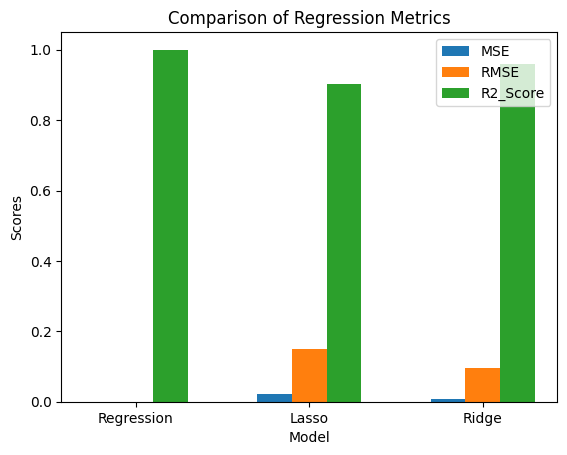

In [ ]:
##2nd student name: Mohamed Jareer MOHAMED  ZEENAM
# add the code here

# plot
import matplotlib.pyplot as plt
import numpy as np

mse = [mse1, mse2, mse3]
rmse = [rmse1, rmse2, rmse3]
r2_score = [r2_score1, r2_score2, r2_score3]

positions = np.arange(len(mse))
bar_width = 0.2

plt.bar(positions - bar_width, mse, width = bar_width, label = 'MSE')
plt.bar(positions, rmse, width = bar_width, label = 'RMSE')
plt.bar(positions + bar_width, r2_score, width = bar_width, label = 'R2_Score')

# adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Metrics')

# adding the legend
plt.legend()
plt.xticks(positions, ['Regression', 'Lasso', 'Ridge'])
plt.show()


---
# **Task 6 - LSEP Considerations (5 marks)**
---

# Student 1: **Type the chosen issue**

add contribution here ...

# Student 2: **Type the chosen issue**

add contribution here ...

---

# **Task 7 - Convert ipynb to HTML for Turnitin submission [5 marks]**

---



In [ ]:
# install nbconvert (if facing the conversion error)
!pip3 install nbconvert

In [ ]:
# convert ipynb to html and submit this HTML file
!jupyter nbconvert --to html Your_Group_ID_CRWK_CN7030.ipynb